In [11]:
import numpy as np
import matplotlib.pyplot as plt

In [12]:
### Core signal and array utilities

def signal(fs, freq, duration):  # Complex exponential
    t = np.arange(0, duration, 1/fs)
    return np.exp(2j * np.pi * freq * t).reshape(1, -1)


def steering_vector(Nr, d, theta_deg): # ULA steering vector column
    theta = np.deg2rad(theta_deg)
    n = np.arange(Nr).reshape(-1, 1)
    return np.exp(2j * np.pi * d * n * np.sin(theta))


def sample_covariance(X):
    return (X @ X.conj().T) / X.shape[1]


def diagonal_loading(R, delta):
    return R + delta * np.eye(R.shape[0])

In [10]:
### Beamformer definitions

def das_weights(s): # Delay and sum weights
    return s / s.shape[0] # Normalizes across Nr = s.shape[0]


def mvdr_weights(R_inv, s): # MVDR weights
    return (R_inv @ s) / (s.conj().T @ R_inv @ s)


def apply_beamformer(w, X):
    return w.conj().T @ X

In [9]:
### DOA spectrum estimators

def das_spectrum(X, d, theta_scan): # Delay and sum beamformer spatial spectrum
    Nr = X.shape[0]
    P = []

    for theta in theta_scan:
        s = steering_vector(Nr, d, theta)
        y = s.conj().T @ X
        P.append(np.var(y))

    P = 10 * np.log10(P)
    return P - np.max(P)


def mvdr_spectrum(R_inv, d, theta_scan): # MVDR spatial spectrum
    Nr = R_inv.shape[0]
    P = []

    for theta in theta_scan:
        s = steering_vector(Nr, d, theta)
        denom = s.conj().T @ R_inv @ s
        P.append(1 / np.real(denom)[0,0])

    P = 10 * np.log10(P)
    return P - np.max(P)


In [4]:
### Plot helpers

def plot_cartesian(theta_scan, P, title):
    plt.figure()
    plt.plot(theta_scan, P)
    plt.xlabel("Angle (degrees)")
    plt.ylabel("Power (dB)")
    plt.title(title)
    plt.grid(True)
    plt.show()


def plot_polar(theta_scan, P, title):
    theta_rad = np.deg2rad(theta_scan)
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    ax.plot(theta_rad, P)
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_thetamin(-90)
    ax.set_thetamax(90)
    ax.set_rlabel_position(55)
    ax.set_title(title)
    plt.show()

In [6]:
### Demo parameters

fs = 48e3
duration = 0.1
theta_scan = np.linspace(-90, 90, 1000)


--- Single Source Demo ---
DAS DOA estimate: 30.0 deg


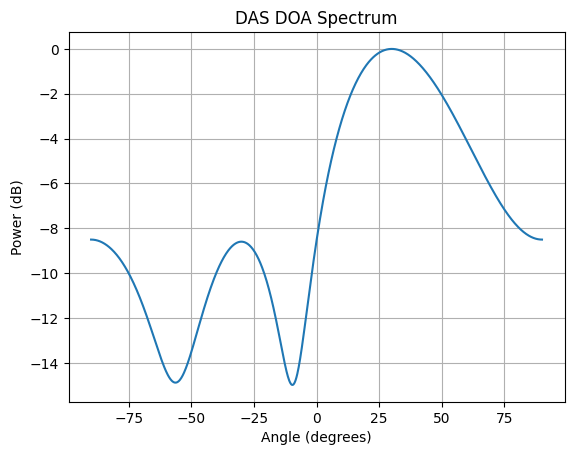

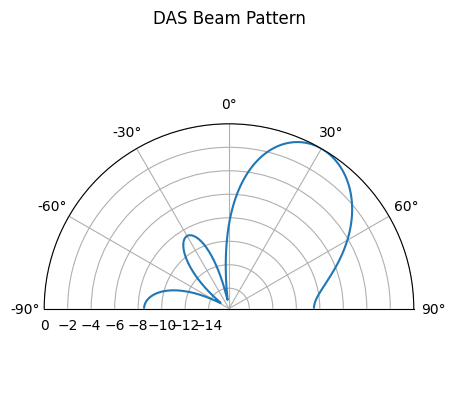

MVDR DOA estimate: 30.0 deg


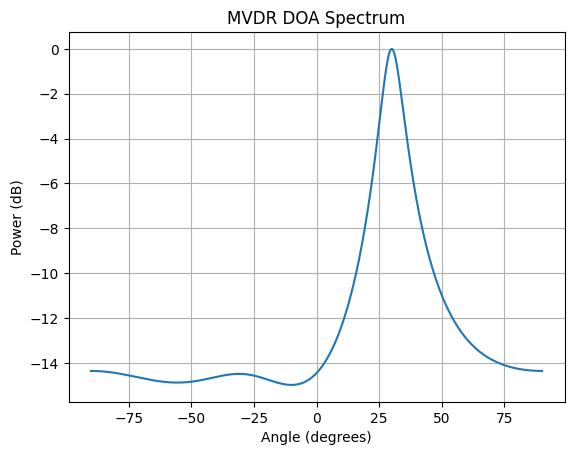

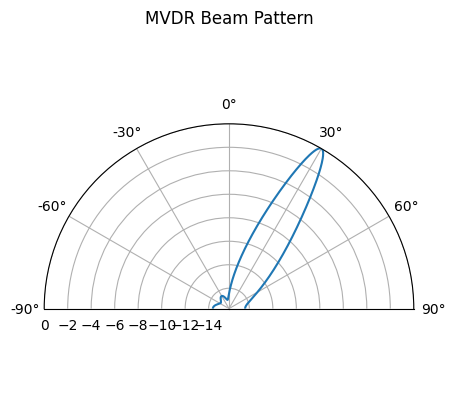

In [15]:
### SINGLE-SOURCE DEMO

print("\n--- Single Source Demo ---")

Nr = 3
d = 0.5
theta_true = 30
snr_db = 10

# Signal + array data
x = signal(fs, 1e3, duration)
s = steering_vector(Nr, d, theta_true)
X = s @ x

# Add noise
signal_power = np.mean(np.abs(X)**2)
noise_power = signal_power / (10**(snr_db/10))
noise = np.sqrt(noise_power/2) * (
    np.random.randn(*X.shape) + 1j*np.random.randn(*X.shape)
)
X += noise

# DAS DOA
P_das = das_spectrum(X, d, theta_scan)
print("DAS DOA estimate:", theta_scan[np.argmax(P_das)], "deg")

plot_cartesian(theta_scan, P_das, "DAS DOA Spectrum")
plot_polar(theta_scan, P_das, "DAS Beam Pattern")

# MVDR DOA
R = sample_covariance(X)
R_inv = np.linalg.inv(R)

P_mvdr = mvdr_spectrum(R_inv, d, theta_scan)
print("MVDR DOA estimate:", theta_scan[np.argmax(P_mvdr)], "deg")

plot_cartesian(theta_scan, P_mvdr, "MVDR DOA Spectrum")
plot_polar(theta_scan, P_mvdr, "MVDR Beam Pattern")

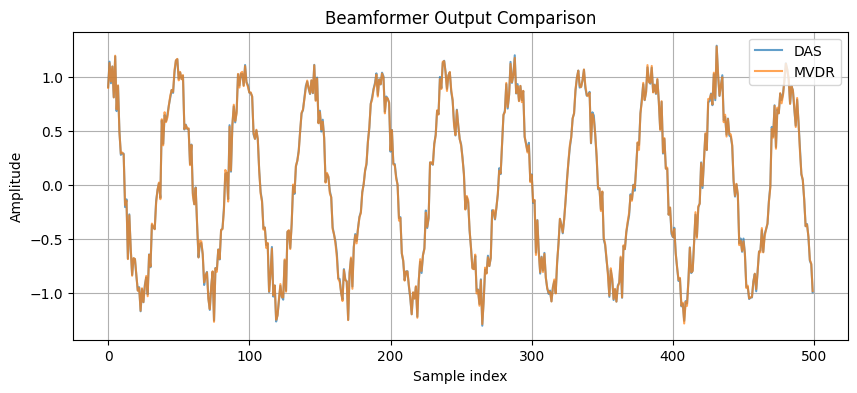

In [14]:
### Time-domain comparison
w_das = das_weights(s)
w_mvdr = mvdr_weights(R_inv, s)

y_das = apply_beamformer(w_das, X)
y_mvdr = apply_beamformer(w_mvdr, X)

plt.figure(figsize=(10,4))
plt.plot(y_das.real.flatten()[:500], label="DAS", alpha=0.7)
plt.plot(y_mvdr.real.flatten()[:500], label="MVDR", alpha=0.7)
plt.legend()
plt.xlabel("Sample index")
plt.ylabel("Amplitude")
plt.title("Beamformer Output Comparison")
plt.grid(True)
plt.show()

X vector shape: (10, 4800)
Strongest MVDR peak at: 30.0 deg


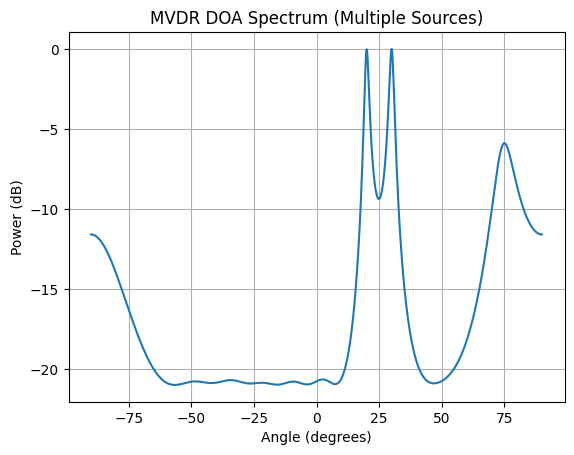

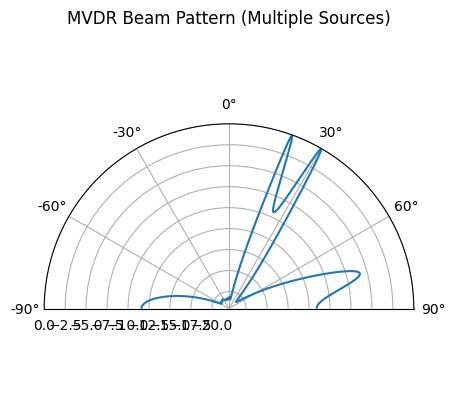

In [16]:
### MULTI-SOURCE DEMO

Nr = 10
d = 0.5

# Source parameters
freqs = [3e3, 9e3, 14e3]
thetas = [20, 30, 75]
gains = [1.0, 1.0, 0.5]

X = np.zeros((Nr, int(fs*duration)), dtype=complex)

for f, th, g in zip(freqs, thetas, gains):
    s = steering_vector(Nr, d, th)
    x = signal(fs, f, duration)
    X += g * (s @ x)

print("X vector shape:", X.shape)

# Add noise
X += 0.2 * (np.random.randn(*X.shape) + 1j*np.random.randn(*X.shape))

# MVDR DOA
R = sample_covariance(X)
R_inv = np.linalg.inv(R)

P_mvdr = mvdr_spectrum(R_inv, d, theta_scan)

print("Strongest MVDR peak at:",
      theta_scan[np.argmax(P_mvdr)], "deg")

plot_cartesian(theta_scan, P_mvdr,
               "MVDR DOA Spectrum (Multiple Sources)")
plot_polar(theta_scan, P_mvdr,
           "MVDR Beam Pattern (Multiple Sources)")